In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xscale

## load mooring data from AODN aggregated timeseries

In [2]:
fname = '/home/z3526974/Work/data/Shelf_moorings/BMP120/IMOS_ANMN-NSW_TZ_20110329_BMP120_FV01_TEMP-aggregated-timeseries_END-20190724_C-20190819.nc'

nc = xr.open_dataset(fname)
nc.LONGITUDE

<xarray.DataArray 'LONGITUDE' (INSTRUMENT: 346)>
array([150.30917, 150.30917, 150.30917, ..., 150.3153 , 150.3153 , 150.3153 ],
      dtype=float32)
Coordinates:
    LONGITUDE      (INSTRUMENT) float32 150.30917 150.30917 ... 150.3153
    LATITUDE       (INSTRUMENT) float32 ...
    NOMINAL_DEPTH  (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT
Attributes:
    axis:             X
    long_name:        longitude
    reference_datum:  WGS84 geographic coordinate system
    standard_name:    longitude
    units:            degrees_east
    valid_max:        180.0
    valid_min:        -180.0

In [3]:
nc.NOMINAL_DEPTH[:5]

<xarray.DataArray 'NOMINAL_DEPTH' (INSTRUMENT: 5)>
array([18., 98., 66., 74., 26.], dtype=float32)
Coordinates:
    LONGITUDE      (INSTRUMENT) float32 150.30917 150.30917 ... 150.30917
    LATITUDE       (INSTRUMENT) float32 ...
    NOMINAL_DEPTH  (INSTRUMENT) float32 ...
Dimensions without coordinates: INSTRUMENT
Attributes:
    axis:             Z
    long_name:        nominal depth
    positive:         down
    reference_datum:  sea surface
    standard_name:    depth
    units:            m
    valid_max:        12000.0
    valid_min:        -5.0

## Read in chosen variables to pandas dataframe

In [4]:
df = pd.DataFrame({'TIME': nc.TIME, 'TEMP': nc.TEMP, 'TEMPqc': nc.TEMP_quality_control, 'DEPTH' : nc.DEPTH}).set_index('TIME')
df.head(5)

,TEMP,TEMPqc,DEPTH
TIME,,,
2011-03-29 22:35:00.000002304,20.814018,1.0,21.745478
2011-03-29 22:40:00.000004352,20.812576,1.0,21.628868
2011-03-29 22:45:00.000006656,20.811136,1.0,21.634703
2011-03-29 22:49:59.999998976,20.815460,1.0,21.576399
2011-03-29 22:55:00.000001024,20.812576,1.0,21.617205


## Apply quality control flags

In [5]:
df.TEMPqc.value_counts()

1.0    9359996
3.0      54494
2.0      31155
4.0       2331
Name: TEMPqc, dtype: int64

In [6]:
df_good = df[df.TEMPqc == 1]
df_good.TEMPqc.value_counts()

1.0    9359996
Name: TEMPqc, dtype: int64

## Resample at 1 hour interval

In [7]:
# This destroys the depth data - don't do this for now
#df_1h = df_good.resample('1H').mean()
#df_1h.head(10)

## Now use groupby to get particular depths

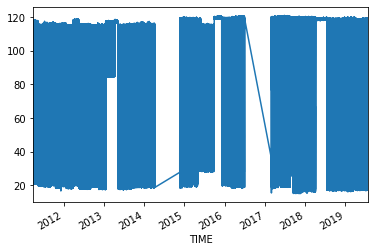

In [8]:
df_good.DEPTH.plot()

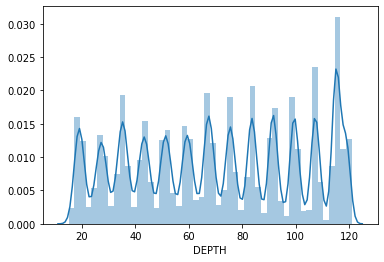

In [9]:
#get distribution of depths
sns.distplot(df_good['DEPTH'].dropna())

In [10]:
binned = pd.cut(x=df_good.DEPTH, bins=[-np.inf, 30, 60,80, np.inf], right=False, labels=['surface', '30-60', '60-80' , 'bottom'])
grouped = df_good.groupby(binned)
surface_temp_1D = grouped.get_group('surface').TEMP.resample('1D').mean()
bottom_temp_1D = grouped.get_group('bottom').TEMP.resample('1D').mean()

In [11]:
# Compute the centered 7-day rolling mean
surface_temp_7D = surface_temp_1D.rolling(7, center=True,min_periods=1).mean()
bottom_temp_7D = bottom_temp_1D.rolling(7, center=True,min_periods=1).mean()

#Compute the centered 365-day rolling mean
surface_temp_1Y = surface_temp_1D.rolling(730, center=True, win_type='hamming',min_periods=100).mean()
bottom_temp_1Y = bottom_temp_1D.rolling(730, center=True, win_type='hamming',min_periods=100).mean()



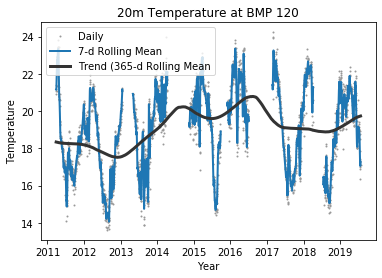

In [12]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(surface_temp_1D, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(surface_temp_7D, linewidth=2, label='7-d Rolling Mean')
ax.plot(surface_temp_1Y, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('20m Temperature at BMP 120');
#plt.savefig('BMP120_20m_temperature_tseries.png', dpi=300,bbox_inches='tight')

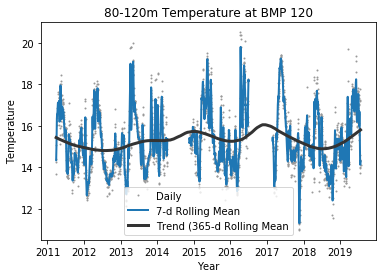

In [13]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(bottom_temp_1D, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(bottom_temp_7D, linewidth=2, label='7-d Rolling Mean')
ax.plot(bottom_temp_1Y, color='0.2', linewidth=3, label='Trend (365-d Rolling Mean')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('80-120m Temperature at BMP 120');
plt.savefig('BMP120_80-120m_temperature_tseries.png', dpi=300,bbox_inches='tight')

## resample at monthly, remove seasonal cycle, add 2 year filter

In [14]:
surface_temp_1M = grouped.get_group('surface').TEMP.resample('1M').mean()
bottom_temp_1M = grouped.get_group('bottom').TEMP.resample('1M').mean()

surface_temp_1M_filt = surface_temp_1M.rolling(24, center=True, win_type='hamming',min_periods=3).mean()
bottom_temp_1M_filt = bottom_temp_1M.rolling(24, center=True, win_type='hamming',min_periods=3).mean()

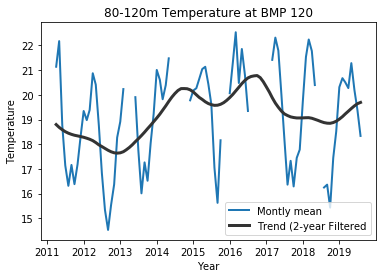

In [15]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(surface_temp_1M, linewidth=2, label='Montly mean')
ax.plot(surface_temp_1M_filt, color='0.2', linewidth=3, label='Trend (2-year Filtered')
# Set x-ticks to yearly interval and add legend and labels
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('80-120m Temperature at BMP 120');

## OK, so this is cute, but to keep things consistent with the SST analysis, and for gapfilling lets rather convert to an Xarray dataset and proceed from there.

In [16]:
DA_surfacetemp = surface_temp_1D.to_xarray()
ds = DA_surfacetemp.to_dataset()
ds = ds.rename({'TIME': 'time'})
ds

<xarray.Dataset>
Dimensions:  (time: 3040)
Coordinates:
  * time     (time) datetime64[ns] 2011-03-29 2011-03-30 ... 2019-07-24
Data variables:
    TEMP     (time) float32 20.93994 21.091053 21.190538 ... 17.2558 17.130167

## Remove seasonal cycle

In [17]:
def xarray_trend(xarr):
    """
    Calculates the trend of the data along the 'time' dimension
    of the input array (xarr).
    USAGE:  x_DS = xarray_trend(xarr)
    INPUT:  xarr is an xarray DataArray with dims:
                time, [lat, lon]
                where lat and/or lon are optional
    OUTPUT: xArray Dataset with:
                original xarr input
                slope
                p-value
    TODO?
    There could be speed improvements (using numpy at the moment)
    """

    from scipy import stats
    # getting shapes

    n = xarr.shape[0]

    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)

    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly

    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)

    # misclaneous additional functions
    # intercept = ym - (slope * xm)
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5

    # preparing outputs
    out = xarr.to_dataset(name=xarr.name)
    # first create variable for slope and adjust meta
    out['slope'] = xarr[:2].mean('time').copy()
    out['slope'].name += '_slope'
    out['slope'].attrs['units'] = 'units / day'
    out['slope'].values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    out['pval'] = xarr[:2].mean('time').copy()
    out['pval'].name += '_Pvalue'
    out['pval'].values = p.reshape(xarr.shape[1:])
    out['pval'].attrs['info'] = ("If p < 0.05 then the results "
                                 "from 'slope' are significant.")

    return out


<xarray.Dataset>
Dimensions:  (time: 3040)
Coordinates:
  * time     (time) datetime64[ns] 2011-03-29 2011-03-30 ... 2019-07-24
Data variables:
    TEMP     (time) float32 20.93994 21.091053 21.190538 ... 17.2558 17.130167
    slope    float64 0.0004451
    pval     float64 4.279e-31

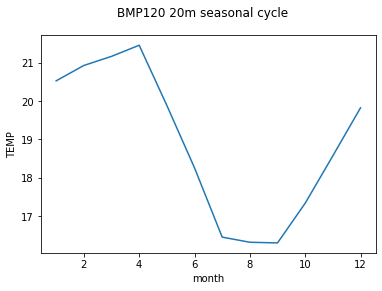

In [18]:
climatology = ds.TEMP.groupby('time.month').mean('time')
anomalies = ds.TEMP.groupby('time.month') - climatology
climatology.plot()
#get linear trend
trend = xarray_trend(ds.TEMP)
plt.suptitle("BMP120 20m seasonal cycle")
plt.savefig('BMP120_20m_seasonal_cycle.png', dpi=300,bbox_inches='tight')
trend

In [19]:
decade_trend = trend.slope*3650
decade_trend

<xarray.DataArray 'slope' ()>
array(1.624553)

<bound method DataArray.to_netcdf of <xarray.DataArray 'TEMP' (time: 3040)>
array([-0.224653, -0.07354 ,  0.025946, ...,  0.883036,  0.807335,  0.681702],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-03-29 2011-03-30 ... 2019-07-24
    month    (time) int64 3 3 3 4 4 4 4 4 4 4 4 4 4 ... 7 7 7 7 7 7 7 7 7 7 7 7>

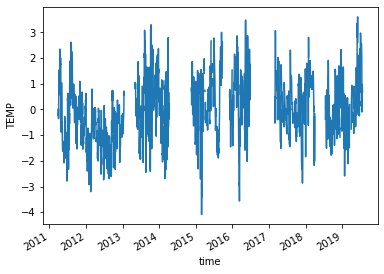

In [20]:
BMP_120_anomalies = anomalies
BMP_120_anomalies.plot()
BMP_120_anomalies.to_netcdf

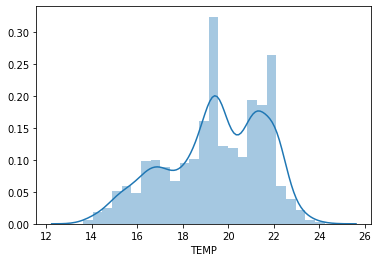

In [21]:
y = surface_temp_1D.fillna(surface_temp_1D.ffill())
sns.distplot(y)